In [ ]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.
This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.
"""
from omegaconf import OmegaConf

def load_dataset(config: OmegaConf):
    from hydra.utils import instantiate
    dataset = instantiate(config.datamodule)
    dataset.prepare_data()
    dataset.setup()
    return dataset

In [ ]:
# make new omegaconf
config10 = OmegaConf.create({
    "datamodule": {
        "_target_": "recipe.datasets.maze.MazeDataset",
        "batch_size": 32,
        "num_workers": 8,
        "return_prediction_mask": True,
        "grid_n": 10,
        "n_mazes": 100
    }
})
config20 = config10.copy()
config20.datamodule.grid_n = 20
config30 = config10.copy()
config30.datamodule.grid_n = 30

ds10 = load_dataset(config10)
ds20 = load_dataset(config20)
ds30 = load_dataset(config30)

In [17]:
def tokens_to_coord(coord_str):
  coord_str = coord_str.strip("()").split(",")
  return tuple(map(int, coord_str))

def edge_to_cntlist_idx(edge):
  # edge is a string like '(2,0) (2,1)'
  # we need to return an index to set to true in the connection list
  # the connection list has dimensions [2, dim, dim]
  # following this logic:
  # if there is a downward connection, [0, x, y] = True, where x y is from the top node
  # if there is a rightward connection, [1, x, y] = True, where x y is from the left node

  # 1. extract coordinates
  edge = edge.split(" ")
  coord1 = tokens_to_coord(edge[0])
  coord2 = tokens_to_coord(edge[1])
  
  #2. sort coordinates to make sure we have the top/left node first
  coords = sorted([coord1, coord2])
  #3. horizontal or vertical connection?
  if coords[0][0] == coords[1][0]:
    # vertical
    return (1,) + coords[0]
  else:
    # horizontal
    return (0,) + coords[0]

def extract_cnctlist_from_tokens(tokens, dim):
  import numpy as np

  start_str = "<ADJLIST_START> "
  idx_start = tokens.index(start_str)
  end_str = " ; <ADJLIST_END>"
  idx_end = tokens.index(end_str)
  tokens = tokens[idx_start + len(start_str):idx_end]
  adjlist = tokens.split(" ; ")
  edge_idxs = [edge_to_cntlist_idx(i) for i in adjlist]
  cnct_list = np.zeros((2, dim, dim), dtype=bool)
  for idx in edge_idxs:
    cnct_list[idx] = True
  return cnct_list

def extract_path_from_tokens(tokens):
  import numpy as np

  start_str = "<PATH_START> "
  idx_start = tokens.index(start_str)
  end_str = " <PATH_END>"
  try:
    idx_end = tokens.index(end_str)
  except ValueError:
    idx_end = len(tokens)
  tokens = tokens[idx_start + len(start_str):idx_end]
  path = tokens.split(" ")
  return np.array([tokens_to_coord(i) for i in path])

def extract_origin_from_tokens(tokens):
  start_str = "<ORIGIN_START> "
  idx_start = tokens.index(start_str)
  end_str = " <ORIGIN_END>"
  idx_end = tokens.index(end_str)
  tokens = tokens[idx_start + len(start_str):idx_end]
  return tokens_to_coord(tokens)

def extract_target_from_tokens(tokens):
  start_str = "<TARGET_START> "
  idx_start = tokens.index(start_str)
  end_str = " <TARGET_END>"
  idx_end = tokens.index(end_str)
  tokens = tokens[idx_start + len(start_str):idx_end]
  return tokens_to_coord(tokens)

def make_solvedmaze_from_tokens(tokens, dim):
  from maze_dataset.maze import SolvedMaze

  connection_list = extract_cnctlist_from_tokens(tokens, dim)
  solution = extract_path_from_tokens(tokens)
  origin = extract_origin_from_tokens(tokens)
  target = extract_target_from_tokens(tokens)
  return SolvedMaze(connection_list=connection_list, solution=solution, start_pos=origin, end_pos=target, allow_invalid=True)

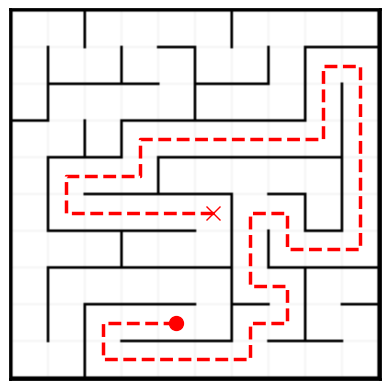

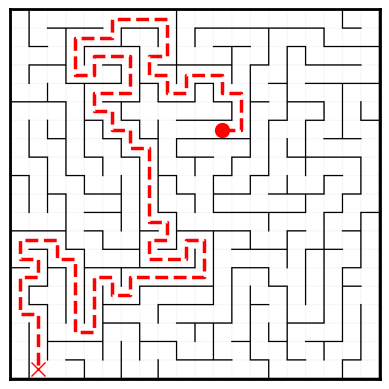

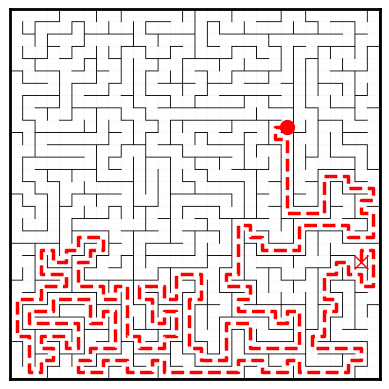

In [29]:
import matplotlib.pyplot as plt
from maze_dataset.plotting import MazePlot
for ds in [ds10, ds20, ds30]:
  test = next(iter(ds.train_dataloader()))["input_ids"][3]
  test = ds.tokenizer.decode(test.tolist())
  maze = make_solvedmaze_from_tokens(test, ds.grid_n)

  plot = MazePlot(maze)
  # plot.add_predicted_path(ans_maze.solution)
  plot.plot()
  # remove y ticks and x ticks
  plt.xticks([])
  plt.yticks([])
  plt.xlabel("")
  plt.ylabel("")
  plt.savefig(f"figures/maze_{ds.grid_n}.pdf", bbox_inches='tight', pad_inches=0)